# Simple SMA Backtest (SPY)

This notebook is a **minimal** backtest:

1. Download prices
2. Compute SMA crossover signals
3. Simulate strategy returns
4. Plot the equity curve
5. Print a few core metrics


---
## What is backtesting?

Backtesting = testing a trading rule on historical prices to see how it would have behaved.
It is a **reality check**, not a guarantee of future results.


---
## Strategy rules (simple)

- Use 50-day and 200-day simple moving averages (SMA)
- **Go long** when SMA50 > SMA200
- **Go to cash** when SMA50 <= SMA200
- No costs or stop-loss in this simple version


In [14]:
# === Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Settings
TICKER = "SPY"
START = "2015-01-01"
END = "2025-01-15"
FAST_MA = 50
SLOW_MA = 200

np.random.seed(42)

print(f"Ticker: {TICKER}")
print(f"Period: {START} to {END}")
print(f"SMA windows: {FAST_MA}/{SLOW_MA}")


Ticker: SPY
Period: 2015-01-01 to 2025-01-15
SMA windows: 50/200


---
## Steps

1. Download prices
2. Compute moving averages and signals
3. Simulate returns
4. Plot equity curve and metrics


In [15]:
# === Step 1: Download prices ===

def get_price(ticker: str) -> pd.Series:
    df = yf.download(ticker, start=START, end=END, auto_adjust=False, progress=False)

    if df is None or df.empty:
        # Simple synthetic fallback if Yahoo is rate-limited
        print("Yahoo data unavailable. Using synthetic prices.")
        dates = pd.date_range(START, END, freq="B")
        rng = np.random.default_rng(42)
        prices = 100 * np.exp(np.cumsum(rng.normal(0.0003, 0.01, len(dates))))
        s = pd.Series(prices, index=dates, name=ticker)
        return s

    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    s = df[col].dropna().squeeze()
    s.name = ticker
    return s

price = get_price(TICKER)
print(f"{TICKER}: {len(price)} days, {price.index[0].date()} to {price.index[-1].date()}")


SPY: 2524 days, 2015-01-02 to 2025-01-14


In [16]:
# === Step 2: Signals ===

df = pd.DataFrame({"price": price})
df["sma_fast"] = df["price"].rolling(FAST_MA).mean()
df["sma_slow"] = df["price"].rolling(SLOW_MA).mean()

# Signal: 1 = long, 0 = cash
# We will execute on the next day to avoid look-ahead bias

df["signal"] = (df["sma_fast"] > df["sma_slow"]).astype(int)
df = df.dropna()

print(df.tail(5))


                 price    sma_fast    sma_slow  signal
Date                                                  
2025-01-07  581.797791  585.121144  545.473493       1
2025-01-08  582.647888  585.366115  545.835651       1
2025-01-10  573.752319  585.397906  546.160379       1
2025-01-13  574.641907  585.428972  546.494254       1
2025-01-14  575.432556  585.510525  546.810741       1


In [17]:
# === Step 3: Backtest ===

df["returns"] = df["price"].pct_change()

# Use yesterday's signal for today's position

df["position"] = df["signal"].shift(1)

# Strategy returns

df["strategy_returns"] = df["position"] * df["returns"]

# Equity curves

df["equity_strategy"] = (1 + df["strategy_returns"]).cumprod()
df["equity_buyhold"] = (1 + df["returns"]).cumprod()

df = df.dropna()

print(df[["price", "signal", "position", "strategy_returns"]].tail(5))


                 price  signal  position  strategy_returns
Date                                                      
2025-01-07  581.797791       1       1.0         -0.011304
2025-01-08  582.647888       1       1.0          0.001461
2025-01-10  573.752319       1       1.0         -0.015267
2025-01-13  574.641907       1       1.0          0.001550
2025-01-14  575.432556       1       1.0          0.001376


---
## Train/test split

For simplicity, we use the full period as one backtest.


---
## Metrics

- Total return
- CAGR
- Sharpe ratio
- Max drawdown


In [18]:
# === Step 4: Metrics ===

def compute_basic_metrics(equity: pd.Series, returns: pd.Series):
    n_years = len(returns) / 252
    total_return = equity.iloc[-1] / equity.iloc[0] - 1
    cagr = (equity.iloc[-1] / equity.iloc[0]) ** (1 / n_years) - 1
    vol = returns.std() * np.sqrt(252)
    sharpe = cagr / vol if vol > 0 else 0
    drawdown = equity / equity.cummax() - 1
    max_dd = drawdown.min()
    return total_return, cagr, sharpe, max_dd

# Strategy metrics
str_total, str_cagr, str_sharpe, str_dd = compute_basic_metrics(
    df["equity_strategy"], df["strategy_returns"].dropna()
)

# Buy & hold metrics
bh_total, bh_cagr, bh_sharpe, bh_dd = compute_basic_metrics(
    df["equity_buyhold"], df["returns"].dropna()
)

print("Strategy")
print(f"  Total return: {str_total:.2%}")
print(f"  CAGR:         {str_cagr:.2%}")
print(f"  Sharpe:       {str_sharpe:.2f}")
print(f"  Max drawdown: {str_dd:.2%}\n")

print("Buy & Hold")
print(f"  Total return: {bh_total:.2%}")
print(f"  CAGR:         {bh_cagr:.2%}")
print(f"  Sharpe:       {bh_sharpe:.2f}")
print(f"  Max drawdown: {bh_dd:.2%}")


Strategy
  Total return: 137.01%
  CAGR:         9.81%
  Sharpe:       0.67
  Max drawdown: -33.72%

Buy & Hold
  Total return: 235.83%
  CAGR:         14.04%
  Sharpe:       0.79
  Max drawdown: -33.72%


### Quick read

- Higher return and Sharpe are better
- Smaller (less negative) max drawdown is better


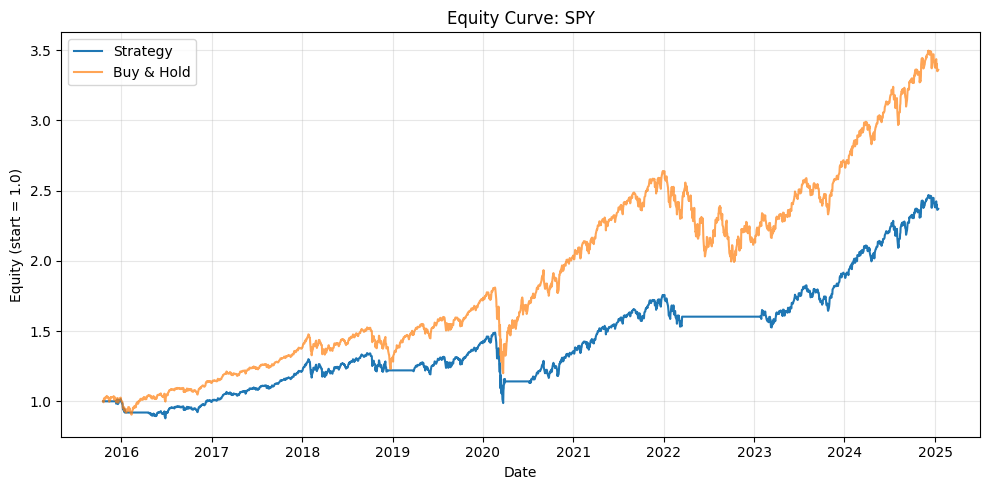

In [19]:
# === Step 5: Plot equity curve ===

plt.figure(figsize=(10, 5))
plt.plot(df.index, df["equity_strategy"], label="Strategy")
plt.plot(df.index, df["equity_buyhold"], label="Buy & Hold", alpha=0.7)
plt.title(f"Equity Curve: {TICKER}")
plt.xlabel("Date")
plt.ylabel("Equity (start = 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---
## End

That's it.
